# Example of Downloading meshes from objaverse for categories like planes or cars and generating point clouds from them

In [2]:
import os

import open3d as o3d

# , point_cloud_generation_from_mesh
from process_msh_ply import ply2projections, knn_patch, as_mesh

import numpy as np
import trimesh
from tqdm import tqdm
from PIL import Image

import time
import cv2

import pandas as pd


## Filter data based on other annotations like names 

Let's load the different names annotated in the dataset and write them to a file so we can look at it:

In [ ]:
import objaverse
import multiprocessing
processes = multiprocessing.cpu_count()

In [ ]:
uids = objaverse.load_uids()
annotations = objaverse.load_annotations()
annotations[uids[0]]

In [ ]:
lvis_annotations = objaverse.load_lvis_annotations()
# get all annotation names from the dictionary
annotation_names = list(lvis_annotations.keys())

# save all annotation names to a csv file
import csv
with open("annotation_names.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(annotation_names)
    

We can select uids based on the names:

In [ ]:
# get all uids for airplane, jet_plane, fighter_jet
airplane_uids = lvis_annotations["airplane"] + lvis_annotations["jet_plane"] + lvis_annotations["fighter_jet"]
print("Number of airplane:", len(airplane_uids))

# get all uids for bicycle
bicycle_uids = lvis_annotations["bicycle"]
print("Number of bicycle:", len(bicycle_uids))

In [ ]:
# load david_holiday_cars.csv and get all the uids
df = pd.read_csv("david_holiday_cars.csv")
car_uids = df["uid"].tolist()
print("Number of cars:", len(car_uids))

example: Let's load the shapes with plane, bicycle or car associated with them.

> Note: You don't neccessarily need the annotations but you could use them to filter the data a little further.

In [ ]:
# get all car annotations
filtered_annotations = objaverse.load_annotations(uids=bicycle_uids)

# filter out the car annotations that have a face count smaller than 100 and save the new uid list
filtered_annotations = {uid: annotation for uid, annotation in filtered_annotations.items(
) if annotation["faceCount"] >= 100}
filtered_uids = list(filtered_annotations.keys())
len(filtered_annotations)

Downloading objects:

In [ ]:
# download the plane objects
downloaded_objects = objaverse.load_objects(
    uids=filtered_uids, download_processes=processes)

In [ ]:
# gives a dictionary of objects with uid as key and the path to the object as value
print(len(downloaded_objects))
downloaded_objects

In [ ]:
# save plane_objects to a csv file using pandas
df = pd.DataFrame.from_dict(downloaded_objects, orient="index")
df.to_csv("bicycle_objects.csv")

# Point cloud generation

In [15]:
class_name = "car" # "airplane", "bicycle", "car"
loaded_objects = pd.read_csv(class_name + "_objects.csv", index_col=0).to_dict()["0"]
len(loaded_objects)

473

In [16]:
def point_cloud_generation_from_mesh(mesh_path, pc_full_path=None):
    # get the folder of the mesh
    mesh_folder = os.path.dirname(mesh_path)
    # find the image in the folder
    image_path = None
    is_obj = False
    if mesh_path.endswith(".obj"):
        is_obj = True
        for f in os.listdir(mesh_folder):
            if f.endswith(".png") or f.endswith(".jpg"):
                image_path = os.path.join(mesh_folder, f)
                break

    scene_or_mesh = trimesh.load_mesh(mesh_path)
    mesh = as_mesh(scene_or_mesh)

    # check if the mesh is watertight and try to fill the holes if necessary
    if not mesh.is_watertight:
        mesh.fill_holes()
    if mesh.is_watertight:
        if len(mesh.split()) > 1:
            print("Mesh has multiple components. Return None.")
            return None

    # rotate mesh to make it face up if it is watertight. 
    if mesh.is_watertight:
        rotation = trimesh.transformations.rotation_matrix(
            np.pi, [0, 1, 1], [0, 0, 0])
        mesh.apply_transform(rotation)
        print("Mesh rotated.")
    if is_obj and image_path is not None:
        img = Image.open(image_path)
        uvs = mesh.visual.uv
        material = trimesh.visual.texture.SimpleMaterial(image=img)
        texture_visual = trimesh.visual.TextureVisuals(
            uv=uvs, image=img, material=material)
        mesh.visual = texture_visual

    if is_obj and image_path is None:
        print("No image found in the folder of obj file. Return point cloud without color.")
        # sample surface without color
        samples, face_index = trimesh.sample.sample_surface(mesh, 50000)
        np_points = np.array(samples)
        pc_from_obj = o3d.geometry.PointCloud()
        pc_from_obj.points = o3d.utility.Vector3dVector(np_points)
    else:
        # generate rgb point cloud
        samples, face_index, colors = trimesh.sample.sample_surface(
            mesh, 50000, sample_color=True)

        np_points = np.array(samples)  # , dtype=np.float32)
        np_colors = np.array(colors, dtype=np.float32)[:, :3]/255.0
        
        pc_from_obj = o3d.geometry.PointCloud()
        pc_from_obj.points = o3d.utility.Vector3dVector(np_points)
        pc_from_obj.colors = o3d.utility.Vector3dVector(np_colors)

    if pc_full_path is not None:
        o3d.io.write_point_cloud(pc_full_path, pc_from_obj)
    
    return pc_from_obj

In [17]:
base_dir = class_name + "_point_clouds"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# go through all plane_objects and generate point clouds
skipped = 0
for uid, mesh_path in tqdm(loaded_objects.items()):
    pc_full_path = os.path.join(base_dir, f"{uid}.ply")
    returned_pc = point_cloud_generation_from_mesh(mesh_path, pc_full_path)
    if returned_pc is None:
        skipped += 1

print(f"Skipped {skipped} objects.")

  0%|          | 1/473 [00:00<07:09,  1.10it/s]

Mesh is not watertight after filling holes.


  0%|          | 2/473 [00:01<06:29,  1.21it/s]

Mesh is not watertight after filling holes.


  1%|          | 3/473 [00:02<04:44,  1.65it/s]

Mesh is not watertight after filling holes.


  1%|          | 4/473 [00:02<03:56,  1.99it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  1%|▏         | 6/473 [00:02<02:53,  2.70it/s]

Mesh is not watertight after filling holes.


  1%|▏         | 7/473 [00:03<03:47,  2.05it/s]

Mesh is not watertight after filling holes.


  2%|▏         | 8/473 [00:03<03:21,  2.30it/s]

Mesh is not watertight after filling holes.


  2%|▏         | 9/473 [00:04<03:02,  2.54it/s]

Mesh is not watertight after filling holes.


  2%|▏         | 10/473 [00:04<02:49,  2.73it/s]

Mesh is not watertight after filling holes.


  2%|▏         | 11/473 [00:07<07:46,  1.01s/it]

Mesh is not watertight after filling holes.


  3%|▎         | 13/473 [00:07<04:23,  1.74it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  3%|▎         | 14/473 [00:07<03:38,  2.10it/s]

Mesh is not watertight after filling holes.


  3%|▎         | 15/473 [00:07<03:11,  2.40it/s]

Mesh is not watertight after filling holes.


  3%|▎         | 16/473 [00:08<04:10,  1.83it/s]

Mesh is not watertight after filling holes.


  4%|▎         | 17/473 [00:09<05:16,  1.44it/s]

Mesh is not watertight after filling holes.


  4%|▍         | 18/473 [00:11<08:28,  1.12s/it]

Mesh is not watertight after filling holes.


  4%|▍         | 19/473 [00:12<06:14,  1.21it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  4%|▍         | 21/473 [00:13<05:25,  1.39it/s]

Mesh is not watertight after filling holes.


  5%|▍         | 22/473 [00:14<05:34,  1.35it/s]

Mesh is not watertight after filling holes.


  5%|▍         | 23/473 [00:14<04:24,  1.70it/s]

Mesh is not watertight after filling holes.


  5%|▌         | 25/473 [00:15<03:30,  2.13it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  6%|▌         | 27/473 [00:15<02:22,  3.13it/s]

Mesh is not watertight after filling holes.


  6%|▌         | 28/473 [00:16<03:06,  2.38it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  6%|▋         | 30/473 [00:16<02:14,  3.29it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  7%|▋         | 32/473 [00:17<01:57,  3.76it/s]

Mesh is not watertight after filling holes.


  7%|▋         | 33/473 [00:17<02:09,  3.39it/s]

Mesh is not watertight after filling holes.


  7%|▋         | 35/473 [00:17<01:45,  4.17it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  8%|▊         | 36/473 [00:17<01:37,  4.48it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  8%|▊         | 38/473 [00:18<01:34,  4.60it/s]

Mesh is not watertight after filling holes.


  8%|▊         | 40/473 [00:18<01:33,  4.63it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


  9%|▊         | 41/473 [00:19<01:51,  3.86it/s]

Mesh is not watertight after filling holes.


  9%|▉         | 42/473 [00:21<06:32,  1.10it/s]

Mesh is not watertight after filling holes.


  9%|▉         | 43/473 [00:22<05:08,  1.40it/s]

Mesh is not watertight after filling holes.


  9%|▉         | 44/473 [00:22<04:26,  1.61it/s]

Mesh is not watertight after filling holes.


 10%|▉         | 45/473 [00:22<04:02,  1.76it/s]

Mesh is not watertight after filling holes.


 10%|▉         | 46/473 [00:23<03:36,  1.97it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 10%|█         | 48/473 [00:24<03:25,  2.07it/s]

Mesh is not watertight after filling holes.


 10%|█         | 49/473 [00:24<03:34,  1.98it/s]

Mesh is not watertight after filling holes.


 11%|█         | 50/473 [00:24<02:55,  2.41it/s]

Mesh is not watertight after filling holes.


 11%|█         | 51/473 [00:25<03:52,  1.81it/s]

Mesh is not watertight after filling holes.


 11%|█         | 53/473 [00:26<02:34,  2.72it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 11%|█▏        | 54/473 [00:26<02:38,  2.64it/s]

Mesh is not watertight after filling holes.


 12%|█▏        | 55/473 [00:27<03:10,  2.20it/s]

Mesh is not watertight after filling holes.


 12%|█▏        | 56/473 [00:27<03:23,  2.05it/s]

Mesh is not watertight after filling holes.


 12%|█▏        | 57/473 [00:28<03:15,  2.13it/s]

Mesh is not watertight after filling holes.


 12%|█▏        | 58/473 [00:28<02:44,  2.53it/s]

Mesh is not watertight after filling holes.


 12%|█▏        | 59/473 [00:28<02:32,  2.71it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 13%|█▎        | 61/473 [00:29<02:14,  3.06it/s]

Mesh is not watertight after filling holes.


 13%|█▎        | 62/473 [00:29<02:10,  3.16it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 14%|█▎        | 64/473 [00:30<02:32,  2.68it/s]

Mesh is not watertight after filling holes.


 14%|█▍        | 66/473 [00:30<01:57,  3.46it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 14%|█▍        | 67/473 [00:31<01:46,  3.82it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 15%|█▍        | 69/473 [00:32<03:34,  1.88it/s]

Mesh is not watertight after filling holes.


 15%|█▍        | 70/473 [00:33<03:04,  2.18it/s]

Mesh is not watertight after filling holes.


 15%|█▌        | 71/473 [00:33<02:50,  2.36it/s]

Mesh is not watertight after filling holes.


 15%|█▌        | 73/473 [00:33<02:00,  3.33it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 16%|█▌        | 74/473 [00:33<02:00,  3.30it/s]

Mesh is not watertight after filling holes.


 16%|█▌        | 75/473 [00:34<02:18,  2.88it/s]

Mesh is not watertight after filling holes.


 16%|█▌        | 76/473 [00:34<02:08,  3.08it/s]

Mesh is not watertight after filling holes.


 16%|█▋        | 77/473 [00:35<03:03,  2.16it/s]

Mesh is not watertight after filling holes.


 16%|█▋        | 78/473 [00:35<03:04,  2.15it/s]

Mesh is not watertight after filling holes.


 17%|█▋        | 79/473 [00:36<02:46,  2.37it/s]

Mesh is not watertight after filling holes.


 17%|█▋        | 80/473 [00:36<03:04,  2.13it/s]

Mesh is not watertight after filling holes.


 17%|█▋        | 81/473 [00:37<02:56,  2.22it/s]

Mesh is not watertight after filling holes.


 18%|█▊        | 83/473 [00:37<02:05,  3.12it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 18%|█▊        | 84/473 [00:38<02:08,  3.04it/s]

Mesh is not watertight after filling holes.


 18%|█▊        | 85/473 [00:38<01:51,  3.48it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 18%|█▊        | 87/473 [00:39<02:24,  2.67it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 19%|█▉        | 90/473 [00:39<01:20,  4.77it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 19%|█▉        | 91/473 [00:39<01:40,  3.82it/s]

Mesh is not watertight after filling holes.


 19%|█▉        | 92/473 [00:40<01:35,  3.97it/s]

Mesh is not watertight after filling holes.


 20%|█▉        | 93/473 [00:40<02:01,  3.14it/s]

Mesh is not watertight after filling holes.


 20%|█▉        | 94/473 [00:41<03:59,  1.58it/s]

Mesh is not watertight after filling holes.


 20%|██        | 95/473 [00:42<03:11,  1.98it/s]

Mesh is not watertight after filling holes.


 20%|██        | 96/473 [00:42<02:59,  2.10it/s]

Mesh is not watertight after filling holes.


 21%|██        | 97/473 [00:43<02:54,  2.15it/s]

Mesh is not watertight after filling holes.


 21%|██        | 98/473 [00:43<02:38,  2.36it/s]

Mesh is not watertight after filling holes.


 21%|██        | 99/473 [00:44<03:36,  1.73it/s]

Mesh is not watertight after filling holes.


 21%|██▏       | 101/473 [00:44<02:17,  2.71it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 22%|██▏       | 103/473 [00:45<02:38,  2.33it/s]

Mesh is not watertight after filling holes.


 22%|██▏       | 104/473 [00:45<02:23,  2.57it/s]

Mesh is not watertight after filling holes.


 22%|██▏       | 105/473 [00:46<03:23,  1.80it/s]

Mesh is not watertight after filling holes.


 22%|██▏       | 106/473 [00:47<02:43,  2.25it/s]

Mesh is not watertight after filling holes.


 23%|██▎       | 107/473 [00:47<02:47,  2.19it/s]

Mesh is not watertight after filling holes.


 23%|██▎       | 108/473 [00:47<02:32,  2.39it/s]

Mesh is not watertight after filling holes.


 23%|██▎       | 109/473 [00:48<03:12,  1.89it/s]

Mesh is not watertight after filling holes.


 23%|██▎       | 110/473 [00:50<04:54,  1.23it/s]

Mesh is not watertight after filling holes.


 23%|██▎       | 111/473 [00:50<04:25,  1.36it/s]

Mesh is not watertight after filling holes.


 24%|██▎       | 112/473 [00:51<04:18,  1.40it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 24%|██▍       | 114/473 [00:52<03:12,  1.87it/s]

Mesh is not watertight after filling holes.


 24%|██▍       | 115/473 [00:52<02:48,  2.12it/s]

Mesh is not watertight after filling holes.


 25%|██▍       | 116/473 [00:52<02:38,  2.25it/s]

Mesh is not watertight after filling holes.


 25%|██▍       | 117/473 [00:52<02:16,  2.61it/s]

Mesh is not watertight after filling holes.


 25%|██▍       | 118/473 [00:53<02:25,  2.43it/s]

Mesh is not watertight after filling holes.


 25%|██▌       | 119/473 [00:53<02:18,  2.56it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 26%|██▌       | 121/473 [00:54<02:17,  2.56it/s]

Mesh is not watertight after filling holes.


 26%|██▌       | 122/473 [00:55<03:08,  1.87it/s]

Mesh is not watertight after filling holes.


 26%|██▌       | 123/473 [00:55<02:48,  2.08it/s]

Mesh is not watertight after filling holes.


 26%|██▌       | 124/473 [00:56<02:44,  2.12it/s]

Mesh is not watertight after filling holes.


 26%|██▋       | 125/473 [00:56<02:28,  2.35it/s]

Mesh is not watertight after filling holes.


 27%|██▋       | 126/473 [00:57<02:54,  1.98it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 27%|██▋       | 129/473 [00:57<01:38,  3.48it/s]

Mesh is not watertight after filling holes.


 28%|██▊       | 131/473 [00:58<01:31,  3.73it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 28%|██▊       | 132/473 [00:58<01:40,  3.40it/s]

Mesh is not watertight after filling holes.


 28%|██▊       | 134/473 [00:59<01:32,  3.65it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 29%|██▊       | 135/473 [00:59<02:23,  2.36it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 29%|██▉       | 137/473 [01:00<02:28,  2.27it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 29%|██▉       | 139/473 [01:01<02:12,  2.52it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 30%|███       | 142/473 [01:03<02:47,  1.98it/s]

Mesh is not watertight after filling holes.


 30%|███       | 143/473 [01:03<02:48,  1.96it/s]

Mesh is not watertight after filling holes.


 31%|███       | 145/473 [01:04<02:05,  2.62it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 31%|███       | 147/473 [01:04<01:58,  2.75it/s]

Mesh is not watertight after filling holes.


 32%|███▏      | 149/473 [01:05<01:45,  3.06it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 32%|███▏      | 150/473 [01:05<01:48,  2.96it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 32%|███▏      | 152/473 [01:06<01:35,  3.37it/s]

Mesh is not watertight after filling holes.


 32%|███▏      | 153/473 [01:07<02:32,  2.10it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 33%|███▎      | 155/473 [01:07<02:10,  2.44it/s]

Mesh is not watertight after filling holes.


 33%|███▎      | 158/473 [01:08<01:18,  4.03it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 34%|███▎      | 159/473 [01:08<01:58,  2.65it/s]

Mesh is not watertight after filling holes.


 34%|███▍      | 160/473 [01:09<02:08,  2.43it/s]

Mesh is not watertight after filling holes.


 34%|███▍      | 161/473 [01:10<02:17,  2.27it/s]

Mesh is not watertight after filling holes.


 34%|███▍      | 162/473 [01:10<02:32,  2.04it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 35%|███▍      | 165/473 [01:10<01:22,  3.71it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 35%|███▌      | 167/473 [01:11<01:01,  5.01it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 36%|███▌      | 168/473 [01:11<01:15,  4.02it/s]

Mesh is not watertight after filling holes.


 36%|███▌      | 169/473 [01:11<01:29,  3.39it/s]

Mesh is not watertight after filling holes.


 36%|███▌      | 170/473 [01:12<01:39,  3.06it/s]

Mesh is not watertight after filling holes.


 36%|███▌      | 171/473 [01:12<01:53,  2.66it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 37%|███▋      | 173/473 [01:13<01:32,  3.26it/s]

Mesh is not watertight after filling holes.


 37%|███▋      | 175/473 [01:13<01:12,  4.10it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 37%|███▋      | 176/473 [01:13<01:00,  4.87it/s]

Mesh is not watertight after filling holes.


 37%|███▋      | 177/473 [01:14<01:23,  3.54it/s]

Mesh is not watertight after filling holes.


 38%|███▊      | 178/473 [01:14<01:16,  3.86it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 38%|███▊      | 180/473 [01:14<01:09,  4.20it/s]

Mesh is not watertight after filling holes.


 38%|███▊      | 181/473 [01:15<01:18,  3.74it/s]

Mesh is not watertight after filling holes.


 38%|███▊      | 182/473 [01:16<02:06,  2.30it/s]

Mesh is not watertight after filling holes.


 39%|███▊      | 183/473 [01:16<02:29,  1.94it/s]

Mesh is not watertight after filling holes.


 39%|███▉      | 184/473 [01:17<02:08,  2.25it/s]

Mesh is not watertight after filling holes.


 39%|███▉      | 185/473 [01:17<02:06,  2.28it/s]

Mesh is not watertight after filling holes.


 39%|███▉      | 186/473 [01:17<01:56,  2.46it/s]

Mesh is not watertight after filling holes.


 40%|███▉      | 187/473 [01:18<01:59,  2.40it/s]

Mesh is not watertight after filling holes.


 40%|███▉      | 188/473 [01:18<01:59,  2.39it/s]

Mesh is not watertight after filling holes.


 40%|███▉      | 189/473 [01:19<02:00,  2.36it/s]

Mesh is not watertight after filling holes.


 40%|████      | 190/473 [01:20<02:35,  1.82it/s]

Mesh is not watertight after filling holes.


 40%|████      | 191/473 [01:20<02:04,  2.27it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 41%|████      | 194/473 [01:20<01:05,  4.28it/s]

Mesh is not watertight after filling holes.


 41%|████      | 195/473 [01:20<01:14,  3.73it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 42%|████▏     | 197/473 [01:21<00:54,  5.09it/s]

Mesh is not watertight after filling holes.


 42%|████▏     | 198/473 [01:22<01:48,  2.54it/s]

Mesh is not watertight after filling holes.


 42%|████▏     | 199/473 [01:22<01:41,  2.70it/s]

Mesh is not watertight after filling holes.


 42%|████▏     | 200/473 [01:22<01:48,  2.51it/s]

Mesh is not watertight after filling holes.


 42%|████▏     | 201/473 [01:23<01:39,  2.72it/s]

Mesh is not watertight after filling holes.


 43%|████▎     | 202/473 [01:24<02:33,  1.77it/s]

Mesh is not watertight after filling holes.


 43%|████▎     | 203/473 [01:24<02:26,  1.84it/s]

Mesh is not watertight after filling holes.


 43%|████▎     | 204/473 [01:25<02:54,  1.54it/s]

Mesh is not watertight after filling holes.


 43%|████▎     | 205/473 [01:26<02:44,  1.63it/s]

Mesh is not watertight after filling holes.


 44%|████▎     | 206/473 [01:26<02:15,  1.97it/s]

Mesh is not watertight after filling holes.


 44%|████▍     | 207/473 [01:27<02:21,  1.88it/s]

Mesh is not watertight after filling holes.


 44%|████▍     | 208/473 [01:27<01:55,  2.30it/s]

Mesh is not watertight after filling holes.


 44%|████▍     | 210/473 [01:27<01:37,  2.70it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 45%|████▍     | 212/473 [01:30<03:33,  1.23it/s]

Mesh is not watertight after filling holes.


 45%|████▌     | 213/473 [01:31<02:58,  1.45it/s]

Mesh is not watertight after filling holes.


 45%|████▌     | 214/473 [01:33<04:22,  1.01s/it]

Mesh is not watertight after filling holes.


 45%|████▌     | 215/473 [01:34<04:41,  1.09s/it]

Mesh is not watertight after filling holes.


 46%|████▌     | 216/473 [01:35<04:11,  1.02it/s]

Mesh is not watertight after filling holes.


 46%|████▌     | 218/473 [01:35<02:22,  1.79it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 46%|████▋     | 219/473 [01:35<01:48,  2.33it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 47%|████▋     | 221/473 [01:36<01:51,  2.26it/s]

Mesh is not watertight after filling holes.


 47%|████▋     | 222/473 [01:36<01:51,  2.25it/s]

Mesh is not watertight after filling holes.


 47%|████▋     | 223/473 [01:38<03:15,  1.28it/s]

Mesh is not watertight after filling holes.


 47%|████▋     | 224/473 [01:39<03:15,  1.27it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 48%|████▊     | 226/473 [01:42<04:24,  1.07s/it]

Mesh is not watertight after filling holes.


 48%|████▊     | 227/473 [01:42<03:53,  1.05it/s]

Mesh is not watertight after filling holes.


 48%|████▊     | 228/473 [01:43<02:57,  1.38it/s]

Mesh is not watertight after filling holes.


 48%|████▊     | 229/473 [01:43<02:19,  1.75it/s]

Mesh is not watertight after filling holes.


 49%|████▊     | 230/473 [01:44<02:40,  1.51it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 49%|████▉     | 231/473 [01:44<02:00,  2.01it/s]

Mesh is not watertight after filling holes.


 49%|████▉     | 233/473 [01:44<01:34,  2.54it/s]

Mesh is not watertight after filling holes.


 49%|████▉     | 234/473 [01:45<01:44,  2.29it/s]

Mesh is not watertight after filling holes.


 50%|████▉     | 235/473 [01:46<02:01,  1.96it/s]

Mesh is not watertight after filling holes.


 50%|█████     | 237/473 [01:46<01:42,  2.31it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 51%|█████     | 239/473 [01:47<01:13,  3.21it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 51%|█████     | 240/473 [01:47<01:32,  2.51it/s]

Mesh is not watertight after filling holes.


 51%|█████     | 241/473 [01:48<01:18,  2.97it/s]

Mesh is not watertight after filling holes.


 51%|█████     | 242/473 [01:48<01:36,  2.40it/s]

Mesh is not watertight after filling holes.


 51%|█████▏    | 243/473 [01:49<01:29,  2.57it/s]

Mesh is not watertight after filling holes.


 52%|█████▏    | 244/473 [01:49<01:23,  2.74it/s]

Mesh is not watertight after filling holes.


 52%|█████▏    | 245/473 [01:50<02:02,  1.86it/s]

Mesh is not watertight after filling holes.


 52%|█████▏    | 246/473 [01:50<01:49,  2.08it/s]

Mesh is not watertight after filling holes.


 52%|█████▏    | 247/473 [01:50<01:38,  2.29it/s]

Mesh is not watertight after filling holes.


 52%|█████▏    | 248/473 [01:51<02:02,  1.83it/s]

Mesh is not watertight after filling holes.


 53%|█████▎    | 249/473 [01:52<02:30,  1.49it/s]

Mesh is not watertight after filling holes.


 53%|█████▎    | 250/473 [01:53<02:47,  1.33it/s]

Mesh is not watertight after filling holes.


 53%|█████▎    | 251/473 [01:55<03:31,  1.05it/s]

Mesh is not watertight after filling holes.


 53%|█████▎    | 252/473 [01:55<02:38,  1.40it/s]

Mesh is not watertight after filling holes.


 53%|█████▎    | 253/473 [01:55<02:16,  1.61it/s]

Mesh is not watertight after filling holes.


 54%|█████▎    | 254/473 [01:55<01:57,  1.87it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 54%|█████▍    | 256/473 [01:56<01:20,  2.69it/s]

Mesh is not watertight after filling holes.


 54%|█████▍    | 257/473 [01:56<01:15,  2.86it/s]

Mesh is not watertight after filling holes.


 55%|█████▍    | 258/473 [01:56<01:09,  3.09it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 55%|█████▍    | 260/473 [01:57<00:48,  4.38it/s]

Mesh is not watertight after filling holes.


 55%|█████▌    | 261/473 [01:57<00:49,  4.28it/s]

Mesh is not watertight after filling holes.


 56%|█████▌    | 263/473 [01:57<00:51,  4.08it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 56%|█████▌    | 264/473 [01:58<00:46,  4.47it/s]

Mesh is not watertight after filling holes.


 56%|█████▌    | 265/473 [01:58<00:52,  3.99it/s]

Mesh is not watertight after filling holes.


 56%|█████▌    | 266/473 [01:58<00:51,  4.03it/s]

Mesh is not watertight after filling holes.


 56%|█████▋    | 267/473 [01:58<00:52,  3.90it/s]

Mesh is not watertight after filling holes.


 57%|█████▋    | 268/473 [01:59<01:01,  3.34it/s]

Mesh is not watertight after filling holes.


 57%|█████▋    | 269/473 [02:00<01:38,  2.07it/s]

Mesh is not watertight after filling holes.


 57%|█████▋    | 270/473 [02:01<02:28,  1.37it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 58%|█████▊    | 273/473 [02:02<01:29,  2.23it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 58%|█████▊    | 274/473 [02:03<01:33,  2.13it/s]

Mesh is not watertight after filling holes.


 58%|█████▊    | 275/473 [02:03<01:28,  2.24it/s]

Mesh is not watertight after filling holes.


 58%|█████▊    | 276/473 [02:03<01:28,  2.22it/s]

Mesh is not watertight after filling holes.


 59%|█████▊    | 277/473 [02:04<01:59,  1.64it/s]

Mesh is not watertight after filling holes.


 59%|█████▉    | 278/473 [02:06<02:51,  1.13it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 59%|█████▉    | 280/473 [02:07<02:08,  1.51it/s]

Mesh is not watertight after filling holes.


 60%|█████▉    | 282/473 [02:07<01:29,  2.14it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 60%|█████▉    | 283/473 [02:08<01:59,  1.58it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 60%|██████    | 285/473 [02:09<01:27,  2.16it/s]

Mesh is not watertight after filling holes.


 60%|██████    | 286/473 [02:10<02:17,  1.36it/s]

Mesh is not watertight after filling holes.


 61%|██████    | 287/473 [02:11<02:18,  1.34it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 61%|██████    | 289/473 [02:12<02:02,  1.51it/s]

Mesh is not watertight after filling holes.


 62%|██████▏   | 292/473 [02:13<01:13,  2.47it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 62%|██████▏   | 293/473 [02:13<01:02,  2.90it/s]

Mesh is not watertight after filling holes.


 62%|██████▏   | 294/473 [02:14<01:46,  1.69it/s]

Mesh is not watertight after filling holes.


 62%|██████▏   | 295/473 [02:15<01:29,  2.00it/s]

Mesh is not watertight after filling holes.


 63%|██████▎   | 296/473 [02:16<01:58,  1.49it/s]

Mesh is not watertight after filling holes.


 63%|██████▎   | 298/473 [02:16<01:14,  2.35it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 63%|██████▎   | 299/473 [02:16<01:05,  2.66it/s]

Mesh is not watertight after filling holes.


 63%|██████▎   | 300/473 [02:17<01:26,  2.00it/s]

Mesh is not watertight after filling holes.


 64%|██████▎   | 301/473 [02:19<02:21,  1.22it/s]

Mesh is not watertight after filling holes.


 64%|██████▍   | 302/473 [02:19<01:49,  1.56it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 64%|██████▍   | 305/473 [02:19<00:53,  3.16it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 65%|██████▍   | 306/473 [02:20<00:58,  2.87it/s]

Mesh is not watertight after filling holes.


 65%|██████▍   | 307/473 [02:21<01:13,  2.25it/s]

Mesh is not watertight after filling holes.


 65%|██████▌   | 308/473 [02:21<01:24,  1.95it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 66%|██████▌   | 310/473 [02:21<00:53,  3.05it/s]

Mesh is not watertight after filling holes.


 66%|██████▌   | 311/473 [02:22<00:58,  2.78it/s]

Mesh is not watertight after filling holes.


 66%|██████▌   | 312/473 [02:22<00:59,  2.70it/s]

Mesh is not watertight after filling holes.


 66%|██████▌   | 313/473 [02:23<00:59,  2.69it/s]

Mesh is not watertight after filling holes.


 66%|██████▋   | 314/473 [02:23<01:17,  2.06it/s]

Mesh is not watertight after filling holes.


 67%|██████▋   | 315/473 [02:25<01:45,  1.49it/s]

Mesh is not watertight after filling holes.


 67%|██████▋   | 316/473 [02:25<01:33,  1.68it/s]

Mesh is not watertight after filling holes.


 67%|██████▋   | 317/473 [02:25<01:17,  2.01it/s]

Mesh is not watertight after filling holes.


 67%|██████▋   | 318/473 [02:26<01:45,  1.47it/s]

Mesh is not watertight after filling holes.


 67%|██████▋   | 319/473 [02:27<01:26,  1.78it/s]

Mesh is not watertight after filling holes.


 68%|██████▊   | 320/473 [02:27<01:21,  1.88it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 68%|██████▊   | 322/473 [02:28<00:58,  2.60it/s]

Mesh is not watertight after filling holes.


 68%|██████▊   | 323/473 [02:28<01:04,  2.34it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 69%|██████▊   | 325/473 [02:29<00:53,  2.75it/s]

Mesh is not watertight after filling holes.


 69%|██████▉   | 326/473 [02:30<01:17,  1.89it/s]

Mesh is not watertight after filling holes.


 69%|██████▉   | 327/473 [02:31<01:27,  1.67it/s]

Mesh is not watertight after filling holes.


 69%|██████▉   | 328/473 [02:31<01:15,  1.91it/s]

Mesh is not watertight after filling holes.


 70%|██████▉   | 329/473 [02:31<01:04,  2.25it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 70%|██████▉   | 331/473 [02:31<00:42,  3.32it/s]

Mesh is not watertight after filling holes.


 70%|███████   | 332/473 [02:32<00:54,  2.58it/s]

Mesh is not watertight after filling holes.


 70%|███████   | 333/473 [02:33<01:30,  1.54it/s]

Mesh is not watertight after filling holes.


 71%|███████   | 334/473 [02:34<01:20,  1.72it/s]

Mesh is not watertight after filling holes.


 71%|███████   | 335/473 [02:34<01:12,  1.90it/s]

Mesh is not watertight after filling holes.


 71%|███████   | 336/473 [02:35<01:06,  2.05it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 71%|███████▏  | 338/473 [02:35<00:45,  2.97it/s]

Mesh is not watertight after filling holes.


 72%|███████▏  | 339/473 [02:35<00:40,  3.33it/s]

Mesh is not watertight after filling holes.


 72%|███████▏  | 340/473 [02:36<01:03,  2.11it/s]

Mesh is not watertight after filling holes.


 72%|███████▏  | 341/473 [02:37<01:11,  1.85it/s]

Mesh is not watertight after filling holes.


 72%|███████▏  | 342/473 [02:37<01:05,  2.01it/s]

Mesh is not watertight after filling holes.


 73%|███████▎  | 343/473 [02:38<01:25,  1.52it/s]

Mesh is not watertight after filling holes.


 73%|███████▎  | 344/473 [02:39<01:31,  1.41it/s]

Mesh is not watertight after filling holes.


 73%|███████▎  | 345/473 [02:41<02:10,  1.02s/it]

Mesh is not watertight after filling holes.


 73%|███████▎  | 346/473 [02:43<02:39,  1.26s/it]

Mesh is not watertight after filling holes.


 73%|███████▎  | 347/473 [02:43<02:03,  1.02it/s]

Mesh is not watertight after filling holes.


 74%|███████▎  | 348/473 [02:44<01:52,  1.11it/s]

Mesh is not watertight after filling holes.


 74%|███████▍  | 349/473 [02:44<01:25,  1.46it/s]

Mesh is not watertight after filling holes.


 74%|███████▍  | 350/473 [02:44<01:07,  1.83it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 74%|███████▍  | 352/473 [02:45<00:58,  2.07it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 75%|███████▍  | 354/473 [02:45<00:49,  2.42it/s]

Mesh is not watertight after filling holes.


 75%|███████▌  | 355/473 [02:46<00:47,  2.46it/s]

Mesh is not watertight after filling holes.


 75%|███████▌  | 356/473 [02:47<00:59,  1.97it/s]

Mesh is not watertight after filling holes.


 75%|███████▌  | 357/473 [02:47<00:49,  2.33it/s]

Mesh is not watertight after filling holes.


 76%|███████▌  | 358/473 [02:47<00:45,  2.52it/s]

Mesh is not watertight after filling holes.


 76%|███████▌  | 360/473 [02:49<00:57,  1.98it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 76%|███████▋  | 361/473 [02:50<01:33,  1.20it/s]

Mesh is not watertight after filling holes.


 77%|███████▋  | 362/473 [02:52<02:07,  1.15s/it]

Mesh is not watertight after filling holes.


 77%|███████▋  | 363/473 [02:53<01:41,  1.08it/s]

Mesh is not watertight after filling holes.


 77%|███████▋  | 364/473 [02:53<01:19,  1.37it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 77%|███████▋  | 366/473 [02:53<00:55,  1.92it/s]

Mesh is not watertight after filling holes.


 78%|███████▊  | 368/473 [02:54<00:45,  2.33it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 78%|███████▊  | 369/473 [02:56<01:41,  1.03it/s]

Mesh is not watertight after filling holes.


 78%|███████▊  | 370/473 [02:57<01:28,  1.16it/s]

Mesh is not watertight after filling holes.


 78%|███████▊  | 371/473 [02:59<02:10,  1.28s/it]

Mesh is not watertight after filling holes.


 79%|███████▊  | 372/473 [03:00<01:46,  1.06s/it]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 79%|███████▉  | 374/473 [03:00<01:01,  1.60it/s]

Mesh is not watertight after filling holes.


 79%|███████▉  | 376/473 [03:01<00:50,  1.91it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 80%|███████▉  | 377/473 [03:02<00:52,  1.83it/s]

Mesh is not watertight after filling holes.


 80%|███████▉  | 378/473 [03:02<00:54,  1.73it/s]

Mesh is not watertight after filling holes.


 80%|████████  | 379/473 [03:03<00:58,  1.62it/s]

Mesh is not watertight after filling holes.


 80%|████████  | 380/473 [03:03<00:46,  2.01it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 81%|████████  | 382/473 [03:03<00:31,  2.90it/s]

Mesh is not watertight after filling holes.


 81%|████████  | 383/473 [03:05<00:47,  1.88it/s]

Mesh is not watertight after filling holes.


 81%|████████  | 384/473 [03:05<00:42,  2.09it/s]

Mesh is not watertight after filling holes.


 81%|████████▏ | 385/473 [03:05<00:42,  2.05it/s]

Mesh is not watertight after filling holes.


 82%|████████▏ | 386/473 [03:07<00:59,  1.47it/s]

Mesh is not watertight after filling holes.


 82%|████████▏ | 387/473 [03:07<01:02,  1.38it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 82%|████████▏ | 389/473 [03:09<00:54,  1.54it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 83%|████████▎ | 391/473 [03:09<00:35,  2.28it/s]

Mesh is not watertight after filling holes.


 83%|████████▎ | 392/473 [03:10<00:44,  1.82it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 83%|████████▎ | 394/473 [03:11<00:45,  1.72it/s]

Mesh is not watertight after filling holes.


 84%|████████▎ | 395/473 [03:11<00:37,  2.07it/s]

Mesh is not watertight after filling holes.


 84%|████████▎ | 396/473 [03:11<00:32,  2.36it/s]

Mesh is not watertight after filling holes.


 84%|████████▍ | 397/473 [03:12<00:30,  2.45it/s]

Mesh is not watertight after filling holes.


 84%|████████▍ | 398/473 [03:12<00:32,  2.28it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 85%|████████▍ | 400/473 [03:12<00:21,  3.32it/s]

Mesh is not watertight after filling holes.


 85%|████████▍ | 401/473 [03:13<00:32,  2.21it/s]

Mesh is not watertight after filling holes.


 85%|████████▌ | 403/473 [03:14<00:23,  2.99it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 85%|████████▌ | 404/473 [03:14<00:24,  2.83it/s]

Mesh is not watertight after filling holes.


 86%|████████▌ | 405/473 [03:15<00:25,  2.71it/s]

Mesh is not watertight after filling holes.


 86%|████████▌ | 406/473 [03:15<00:23,  2.84it/s]

Mesh is not watertight after filling holes.


 86%|████████▌ | 407/473 [03:16<00:28,  2.31it/s]

Mesh is not watertight after filling holes.


 86%|████████▋ | 408/473 [03:16<00:33,  1.91it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 87%|████████▋ | 410/473 [03:17<00:23,  2.69it/s]

Mesh is not watertight after filling holes.


 87%|████████▋ | 411/473 [03:19<00:53,  1.16it/s]

Mesh is not watertight after filling holes.


 87%|████████▋ | 413/473 [03:20<00:41,  1.44it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 88%|████████▊ | 414/473 [03:20<00:32,  1.79it/s]

Mesh is not watertight after filling holes.


 88%|████████▊ | 415/473 [03:21<00:27,  2.15it/s]

Mesh is not watertight after filling holes.


 88%|████████▊ | 416/473 [03:21<00:31,  1.79it/s]

Mesh is not watertight after filling holes.


 88%|████████▊ | 417/473 [03:22<00:26,  2.09it/s]

Mesh is not watertight after filling holes.


 88%|████████▊ | 418/473 [03:23<00:36,  1.51it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 89%|████████▉ | 420/473 [03:23<00:20,  2.56it/s]

Mesh is not watertight after filling holes.


 89%|████████▉ | 421/473 [03:25<00:44,  1.18it/s]

Mesh is not watertight after filling holes.


 89%|████████▉ | 422/473 [03:25<00:35,  1.42it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 90%|████████▉ | 425/473 [03:26<00:20,  2.32it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 90%|█████████ | 426/473 [03:28<00:33,  1.39it/s]

Mesh is not watertight after filling holes.


 90%|█████████ | 427/473 [03:28<00:29,  1.54it/s]

Mesh is not watertight after filling holes.


 90%|█████████ | 428/473 [03:29<00:27,  1.64it/s]

Mesh is not watertight after filling holes.


 91%|█████████ | 429/473 [03:29<00:24,  1.78it/s]

Mesh is not watertight after filling holes.


 91%|█████████ | 430/473 [03:29<00:21,  2.00it/s]

Mesh is not watertight after filling holes.


 91%|█████████▏| 432/473 [03:31<00:22,  1.85it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 92%|█████████▏| 433/473 [03:31<00:18,  2.15it/s]

Mesh is not watertight after filling holes.


 92%|█████████▏| 434/473 [03:31<00:16,  2.40it/s]

Mesh is not watertight after filling holes.


 92%|█████████▏| 435/473 [03:32<00:15,  2.42it/s]

Mesh is not watertight after filling holes.


 92%|█████████▏| 436/473 [03:33<00:19,  1.88it/s]

Mesh is not watertight after filling holes.


 93%|█████████▎| 438/473 [03:34<00:18,  1.87it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 93%|█████████▎| 439/473 [03:35<00:22,  1.51it/s]

Mesh is not watertight after filling holes.


 93%|█████████▎| 440/473 [03:36<00:28,  1.14it/s]

Mesh is not watertight after filling holes.


 93%|█████████▎| 441/473 [03:40<00:59,  1.86s/it]

Mesh is not watertight after filling holes.


 93%|█████████▎| 442/473 [03:42<00:56,  1.82s/it]

Mesh is not watertight after filling holes.


 94%|█████████▎| 443/473 [03:44<00:52,  1.77s/it]

Mesh is not watertight after filling holes.


 94%|█████████▍| 444/473 [03:45<00:45,  1.56s/it]

Mesh is not watertight after filling holes.


 94%|█████████▍| 445/473 [03:46<00:36,  1.31s/it]

Mesh is not watertight after filling holes.


 94%|█████████▍| 446/473 [03:46<00:31,  1.17s/it]

Mesh is not watertight after filling holes.


 95%|█████████▍| 447/473 [03:47<00:25,  1.01it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 95%|█████████▍| 449/473 [03:47<00:14,  1.70it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 95%|█████████▌| 451/473 [03:48<00:09,  2.29it/s]

Mesh is not watertight after filling holes.


 96%|█████████▌| 452/473 [03:48<00:08,  2.61it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 96%|█████████▌| 454/473 [03:49<00:08,  2.16it/s]

Mesh is not watertight after filling holes.


 96%|█████████▌| 455/473 [03:49<00:08,  2.06it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 96%|█████████▋| 456/473 [03:50<00:06,  2.48it/s]

Mesh is not watertight after filling holes.


 97%|█████████▋| 458/473 [03:50<00:05,  2.70it/s]

Mesh is not watertight after filling holes.


 97%|█████████▋| 459/473 [03:52<00:08,  1.66it/s]

Mesh is not watertight after filling holes.


 97%|█████████▋| 460/473 [03:52<00:06,  2.10it/s]

Mesh is not watertight after filling holes.


 97%|█████████▋| 461/473 [03:52<00:05,  2.08it/s]

Mesh is not watertight after filling holes.


 98%|█████████▊| 462/473 [03:53<00:06,  1.62it/s]

Mesh is not watertight after filling holes.


 98%|█████████▊| 463/473 [03:55<00:09,  1.00it/s]

Mesh is not watertight after filling holes.


 98%|█████████▊| 465/473 [03:56<00:04,  1.66it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 99%|█████████▊| 466/473 [03:56<00:04,  1.61it/s]

Mesh is not watertight after filling holes.


 99%|█████████▊| 467/473 [03:58<00:04,  1.22it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


 99%|█████████▉| 469/473 [03:58<00:02,  1.83it/s]

Mesh is not watertight after filling holes.


 99%|█████████▉| 470/473 [03:58<00:01,  1.94it/s]

Mesh is not watertight after filling holes.


100%|█████████▉| 471/473 [03:59<00:01,  1.88it/s]

Mesh is not watertight after filling holes.
Mesh is not watertight after filling holes.


100%|██████████| 473/473 [04:02<00:00,  1.95it/s]

Mesh is not watertight after filling holes.
Skipped 0 objects.


In [19]:
import matplotlib.pyplot as plt

Mesh is not watertight after filling holes.
./tmp/pc_from_obj.ply
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


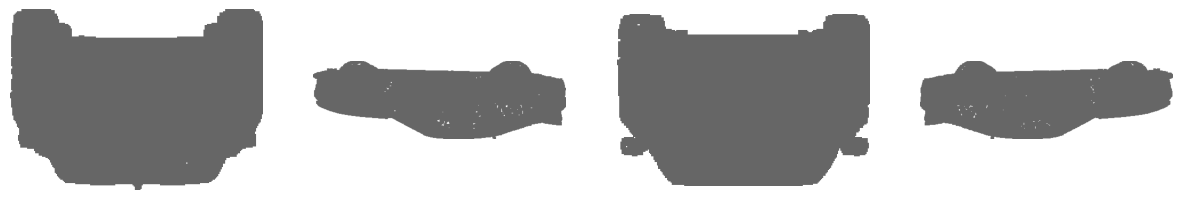

In [25]:
# Test for single mesh to point cloud
plane_uids = list(loaded_objects.keys())
selected_element = loaded_objects[plane_uids[5]]

pc_from_obj = point_cloud_generation_from_mesh(selected_element, pc_full_path="./tmp/pc_from_obj.ply")
if pc_from_obj is None:
    print("Point cloud is None.")
else:
    full_path = "./tmp/pc_from_obj.ply"
    imgs = ply2projections(full_path)

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, img in enumerate(imgs):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()